In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
cd drive

/content/drive


In [ ]:
cd MyDrive/

/content/drive/MyDrive


In [ ]:
cd Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
ls

bayesian_cnn_test.ipynb  commit.ipynb            transformer/
bayesian_nn_test.ipynb   savefig_default222.png


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

class SimpleConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, stride, kernel_size):
        super(SimpleConv2D, self).__init__()
        self.kernel_size = kernel_size
        self.weight = torch.nn.Parameter(torch.randn(out_channels, in_channels, kernel_size[0], kernel_size[1]))
        self.bias = torch.nn.Parameter(torch.randn(out_channels))
        self.stride = stride
        torch.nn.init.uniform_(self.weight, -1, 1)
        torch.nn.init.uniform_(self.bias, -1, 1)
    def rep(self, mu):
        return mu + torch.randn_like(mu)*0.1

    def forward(self, x):
        batch_size, in_channels, height, width = x.shape

        out_channels = self.weight.shape[0]

        output_height = (height - self.kernel_size[0])//self.stride + 1
        output_width = (width - self.kernel_size[1])//self.stride + 1
        patches = torch.zeros((batch_size, output_height, output_width, in_channels, self.kernel_size[0], self.kernel_size[1]))
        for i in range(output_height):
            for j in range(output_width):
                patches[:, i, j] = x[:, :, self.stride*i:self.stride*i+self.kernel_size[0], self.stride*j:self.stride*j+self.kernel_size[1]]

        #self.weight = self.weight.reshape(out_channels, -1)
        #patches  = patches.reshape(batch_size, output_height, output_width, -1)
        W = self.rep(self.weight)
        B = self.rep(self.bias)

        output = torch.einsum('abcd,efgbcd->eafg', [W, patches])
        #print(output.size())
        output = output #+ B[None,:, None, None]
        #print(B[None,:, None, None].size())
        return output

    def kldloss(self):

        return torch.sum(torch.square(self.weight)) + torch.sum(torch.square(self.bias))

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = SimpleConv2D(1, 8, 5, (5,5))  # Input channels: 1, Output channels: 16, Kernel size: 3
        self.conv2 = SimpleConv2D(8, 32, 5, (5,5)) # Input channels: 16, Output channels: 32, Kernel size: 3
        self.weight_1 = torch.nn.Parameter(torch.randn(32, 10))
        torch.nn.init.uniform_(self.weight_1, -1, 1)
        self.weight_2 = torch.nn.Parameter(torch.randn(10, 1))
        torch.nn.init.uniform_(self.weight_2, -1, 1)
        #self.fc1 = torch.nn.Linear(32 * 2 * 2, 10) # Fully connected layer
        #self.fc2 = torch.nn.Linear(10, 1) # Fully connected layer
        self.relu = torch.nn.LeakyReLU(0.1)
        self.avgpool = torch.nn.AvgPool2d(2)

    def rep(self, mu):
        return mu + torch.randn_like(mu)*0.1

    def forward(self, x):
        W_1 = self.rep(self.weight_1)
        W_2 = self.rep(self.weight_2)

        x = self.relu(self.conv1(x))
        x = self.avgpool(x)

        x = self.relu(self.conv2(x))
        x = self.avgpool(x)

        x = x.view(x.size(0), -1) # Flatten the tensor
        x = torch.matmul(x, W_1)
        x = self.relu(x)

        x = torch.matmul(x, W_2)
        return x

    def kldloss(self):
      return self.conv1.kldloss() + self.conv2.kldloss() + torch.sum(torch.square(self.weight_1)) + torch.sum(torch.square(self.weight_2))

simple_cnn = SimpleCNN()



tmp_data = torch.tensor([[-5, -12, 5], [-5, 7, 5], [-5, 9, 4],
                         [-3, -10, 5], [-3, 5, 5], [-3, 8, 4],
                         [-2, 2, 5], [-1, 2, 5], [-1, 3, 4],
                         [-1, -4, 3], [0, 1, 1], [1, 10, -1],
                         [2, -2, -3], [3, 2, -4], [4, 14, -5],
                         [5, -4, -4], [5, 5, -3], [6, 4, -2],
                         [7, -14, -1], [8, 3, 0], [8, 12, 1],
                         [9, -6, 3], [10, 12, 6]])
batch_size = 23





In [ ]:
train_dataloader = DataLoader(tmp_data, batch_size=23, shuffle=False)
optimizer = torch.optim.SGD(simple_cnn.parameters(), lr=0.00001)
def convert_map(data):
  data2 = torch.zeros(len(data),100,100) - 0.1
  i = 0
  while i < len(data):
    data2[i][int(data[i][0])+50][int(data[i][1])+50] = 1
    i = i + 1
  return data2

i = 0
while i < 100000:
    train_data = next(iter(train_dataloader))
    newdata = torch.split(train_data, 2, dim = 1)
    input_tensor = convert_map(newdata[0]).unsqueeze(1)
    output = simple_cnn(input_tensor)
    likelihood = torch.sum(torch.square(newdata[1].squeeze() - output.squeeze()))

    loss = likelihood + simple_cnn.kldloss()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%100 == 0:
      print("newdata", newdata[1].squeeze())
      print("output", output.squeeze())
      print("lik",likelihood)
      print(simple_cnn.kldloss())
    i = i + 1



newdata tensor([ 5,  5,  4,  5,  5,  4,  5,  5,  4,  3,  1, -1, -3, -4, -5, -4, -3, -2,
        -1,  0,  1,  3,  6])
output tensor([ 4.1058,  4.8649,  3.8253,  4.8491,  4.6594,  4.0919,  4.9132,  4.3499,
         4.0479,  2.8227,  1.4475, -0.2058, -2.6387, -2.9842, -3.8264, -3.1195,
        -1.6816, -1.1809,  0.1177,  0.9278,  1.2693,  3.0279,  5.3824],
       grad_fn=<SqueezeBackward0>)
lik tensor(10.5795, grad_fn=<SumBackward0>)
tensor(117.7712, grad_fn=<AddBackward0>)
newdata tensor([ 5,  5,  4,  5,  5,  4,  5,  5,  4,  3,  1, -1, -3, -4, -5, -4, -3, -2,
        -1,  0,  1,  3,  6])
output tensor([ 4.3102,  5.7508,  3.9271,  4.3422,  4.4823,  3.9182,  5.1144,  4.2567,
         3.4475,  2.3998,  0.8652, -0.5442, -2.7015, -3.3261, -4.0507, -3.4133,
        -2.7670, -1.7076, -0.4281,  0.3884,  0.5081,  2.7731,  5.8612],
       grad_fn=<SqueezeBackward0>)
lik tensor(5.9281, grad_fn=<SumBackward0>)
tensor(117.7297, grad_fn=<AddBackward0>)
newdata tensor([ 5,  5,  4,  5,  5,  4,  5,  5,  

KeyboardInterrupt: ignored

tensor([[[-1.1690e+00, -1.1690e+00],
         [-6.3989e-01, -6.3989e-01],
         [ 3.2435e-02,  3.2435e-02],
         ...,
         [-4.7003e-03, -4.7003e-03],
         [ 4.3043e-02,  4.3043e-02],
         [-1.9187e-02, -1.9187e-02]],

        [[-1.7495e-01, -1.7495e-01],
         [ 4.8024e-02,  4.8024e-02],
         [-9.5907e-01, -9.5907e-01],
         ...,
         [ 2.6890e+00,  2.6890e+00],
         [-2.4624e-02, -2.4624e-02],
         [ 2.2929e+00,  2.2929e+00]],

        [[-7.3521e-01, -7.3521e-01],
         [ 2.9639e-02,  2.9639e-02],
         [-1.1815e+00, -1.1815e+00],
         ...,
         [ 1.9902e-01,  1.9902e-01],
         [ 1.3942e-02,  1.3942e-02],
         [-2.0516e-03, -2.0516e-03]],

        ...,

        [[-2.1377e-01, -2.1377e-01],
         [ 2.1616e-02,  2.1616e-02],
         [ 7.1888e-01,  7.1888e-01],
         ...,
         [ 1.0586e-01,  1.0586e-01],
         [ 3.9433e-02,  3.9433e-02],
         [-8.9419e-03, -8.9419e-03]],

        [[-1.5934e+00, -1.5934e+00

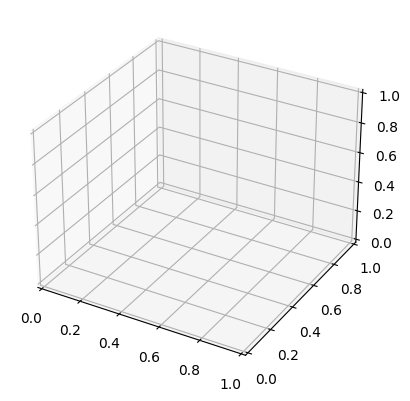

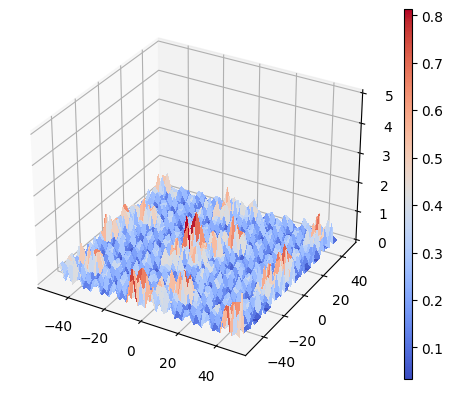

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-50, 50, 2)
Y = np.arange(-50, 50, 2)
X, Y = np.meshgrid(X, Y)
#print(np.shape(X))
#print(torch.tensor(X).unsqueeze(-1))
#print(np.shape(Y))
#print(Y)
def convert_map(data):
  data2 = torch.zeros(len(data),100,100)
  i = 0
  while i < len(data):
    data2[i][int(data[i][0])+50][int(data[i][1])+50] = 1
    i = i + 1
  return data2
newx = torch.tensor(X).unsqueeze(-1).type(torch.float32)
newy = torch.tensor(Y).unsqueeze(-1).type(torch.float32)
newxy = torch.cat((newx, newy), -1)
minimax = torch.zeros((50,50,2), dtype = torch.float32)
ci = 0
while ci<50:
  i = 0
  while i < 50: #y
    j = 0
    while j < 50: #x
      patch = newxy[i][j]
      patch = convert_map(patch.unsqueeze(0))
      input_data = patch.unsqueeze(0)
      tmp_data = simple_cnn(input_data).squeeze()
      if ci == 0:
        minimax[i][j][0] = tmp_data
        minimax[i][j][1] = tmp_data
      if minimax[i][j][0] < tmp_data:
        minimax[i][j][0] = tmp_data
      elif minimax[i][j][1] > tmp_data:
        minimax[i][j][1] = tmp_data
      j = j + 1
    i = i + 1
  print(minimax)
  ci = ci + 1

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
z = minimax[:, :, 0] - minimax[:, :, 1]

# Plot the surface.
surf = ax.plot_surface(X, Y, z.detach().numpy(), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 5)
# ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=1, aspect=50)
plt.savefig('savefig_default222.png')
plt.show()

device cuda
